In [1]:
from FeedForwardNN import Feedforward
from Toy_Datasets import two_clusters_gaussian, plot_decision_boundary
from Neural_Network import NLM,Classifier
import autograd.numpy as np
from sklearn.linear_model import LogisticRegression
from autograd import grad
import autograd.numpy as np
from autograd import grad
import matplotlib.pyplot as plt
from autograd.misc.optimizers import adam
from Bayesian_pdf import get_log_prior, get_log_likelihood
from Hamiltonian_MC import hmc
from sklearn.model_selection import train_test_split
from pandas import get_dummies

In [2]:
from platform import python_version
print(python_version())

3.8.5


In [3]:
def two_clusters_gaussian(params, n_samples, test_points=None):
    """
    :param params: should be a list of length K, K being the number of classes you wish to create
    for every class 0 <= k <=K-1, params[k] should be a dictionnary containing two keys: mean and covariance_matrix.
    The shapes expected for mean are D and covariance_matrix are D*D where D is the number of features for every
    datapoint.
    :param n_samples: number of samples you wish to create for every cluster
    :param test_points: OOD points
    :return: x of len(K*n_samples, n_features) and y of shape (K*n_samples). For both x and y, the features pertain
    sequentially to every class 0 <= k <= K-1
    """
    if params:
        if isinstance(params, list):  # params is a list
            K = len(params)
        else:  # params is a numpy array
            K = params.shape[0]	
        x = np.array([0, 0])
        for k, param in enumerate(params):
            param_k = params[k]
            try:
                mean_k, cov_k = param_k['mean'], param_k['covariance_matrix']
            except KeyError:
                raise KeyError('The parameters for class ' + str(k) + 'are not in the right dictionnary format. Please use mean and covariance_matrix')
            assert len(mean_k) == cov_k.shape[0] == cov_k.shape[1], 'Wrong shapes for the parameters of class ' + str(k)
            samples_class_k = np.random.multivariate_normal(mean_k, cov_k, n_samples)
            x = np.vstack((x, samples_class_k))
        y = np.array([[k] * n_samples for k in range(K)])
        return x[1:, :], np.array(y).flatten()
    else:
        raise BaseException().args

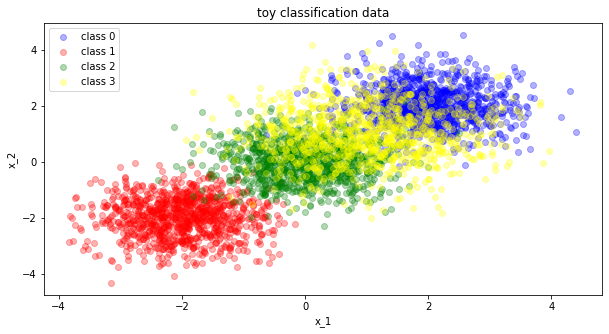

In [4]:
params_1 = {'mean': [2, 2], 'covariance_matrix': 0.5*np.eye(2)}
params_2 = {'mean': [-2, -2], 'covariance_matrix': 0.5 * np.eye(2)}
params_3 = {'mean': [0, 0], 'covariance_matrix': 0.5 * np.eye(2)}
params_4 = {'mean': [1, 1], 'covariance_matrix': 1 * np.eye(2)}

params = [params_1, params_2,params_3,params_4]
x, y = two_clusters_gaussian(params, 1000)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 2, 0], x[y == 2, 1], alpha=0.3, color='green', label='class 2')
ax.scatter(x[y == 3, 0], x[y == 3, 1], alpha=0.3, color='yellow', label='class 3')

ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data')
ax.legend(loc='best')
plt.show()

# test BNN
* 4 classes
* output dim = 4
* batch = 200

In [20]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 4

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [21]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':15000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
nn.fit(X_train.T, y_train.T, params)

#print(y_)
#X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
#nlm.fit_MLE(X_train.T, y_train.T, params)

ValueError: shapes (1,4,3200) and (12800,) not aligned: 3200 (dim 2) != 12800 (dim 0)

In [ ]:
#print(nn.forward(nn.weights,x.T)[0][0][:100],'\n')
#print(nn.forward(nn.weights,x.T)[0][0][100:200],'\n')
#print(nn.forward(nn.weights,x.T)[0][0][200:],'\n')
print(nn.forward(nn.weights,x.T))

In [ ]:
params_hmc={
       'num_samples':2000,
       'step_size':1e-2, 
       'L':20,
       'init': nn.weights,
       'burn':.1, 
       'thin':2,
}


def log_prior(W):
    Sigma=25*np.eye(nn.D)
    D_bayes=Sigma.shape[0]
    Sigma_inv= np.linalg.inv(Sigma)
    Sigma_det = np.linalg.det(Sigma)
    constant_W = -0.5 * (D_bayes * np.log(2 * np.pi) + np.log(Sigma_det))
    exponential_W = -0.5 * np.diag(np.dot(np.dot(W, Sigma_inv), W.T))
    log_p_W = constant_W + exponential_W
    return log_p_W

def log_likelihood(W):
    D_bayes=len(y.reshape((-1,1)))
    sigma_y=0.5
    constant = (-np.log(sigma_y) - 0.5 * np.log(2 * np.pi)) * D_bayes
    #print(constant)
    exponential = (-0.5 * sigma_y**-2 * np.sum((y.reshape((1, D_bayes)).T - (nn.forward(W, x.T)))**2, axis=1).flatten()).mean()
    #print(exponential)
    return constant + exponential

q=hmc(log_prior, log_likelihood, **params_hmc)

#log_likelihood(nn.weights)


In [13]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def HMC_Unit_test():
    # Generate a toy dataset for classification
    samples = 100
    class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
    class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
    x = np.vstack((class_0, class_1))
    y = np.array([0] * 100 + [1] * 100)
    mean = np.zeros(3)
    cov = 10*np.eye(3)
    D = 3

    def log_likelihood(w):
        theta = sigmoid(w[-1] + np.dot(x, w[:-1]))
        return np.sum(np.log(theta[y==1])) + np.sum(np.log(1 - theta[y==0]))

    def log_normal_prior(W):
        logprior = -0.5 * (np.log(np.linalg.det(cov)) + D * np.log(2 * np.pi))
        logprior += -0.5 * np.dot(np.dot(W-mean, np.linalg.inv(cov)), (W-mean).T)
        return logprior
    
    log_prior = log_normal_prior
    log_likelihood = log_likelihood
    lr = LogisticRegression(C=1., penalty='l2', solver='saga', tol=0.1)
    lr.fit(x, y)
    position_init = np.hstack((lr.coef_.flatten(), lr.intercept_))
    position_init = position_init.reshape((1, 3))[0]
    samples = hmc(log_prior, log_likelihood, 1000,  1e-1, 20, position_init, 0.1, 1)
    q_=np.asarray(samples).T
    plt.plot(range(len(q_[0])),q_[0] , color='r')
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(q_[0], lags=50)
    plt.show()
    #print(log_likelihood(position_init))
    return samples


100 : 0.69
200 : 0.68
300 : 0.6933333333333334
400 : 0.685
500 : 0.674
600 : 0.675
700 : 0.67
800 : 0.665
900 : 0.6688888888888889


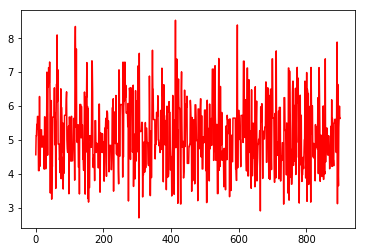

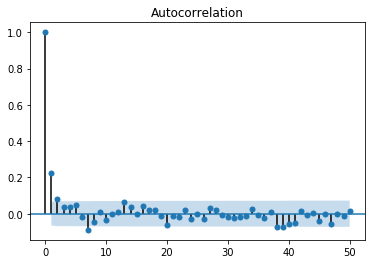

In [14]:
samples=HMC_Unit_test()

Text(0.5, 1.0, 'toy classification data with test data points and the linear boundary decision outputted by the posterior distribution for parameters')

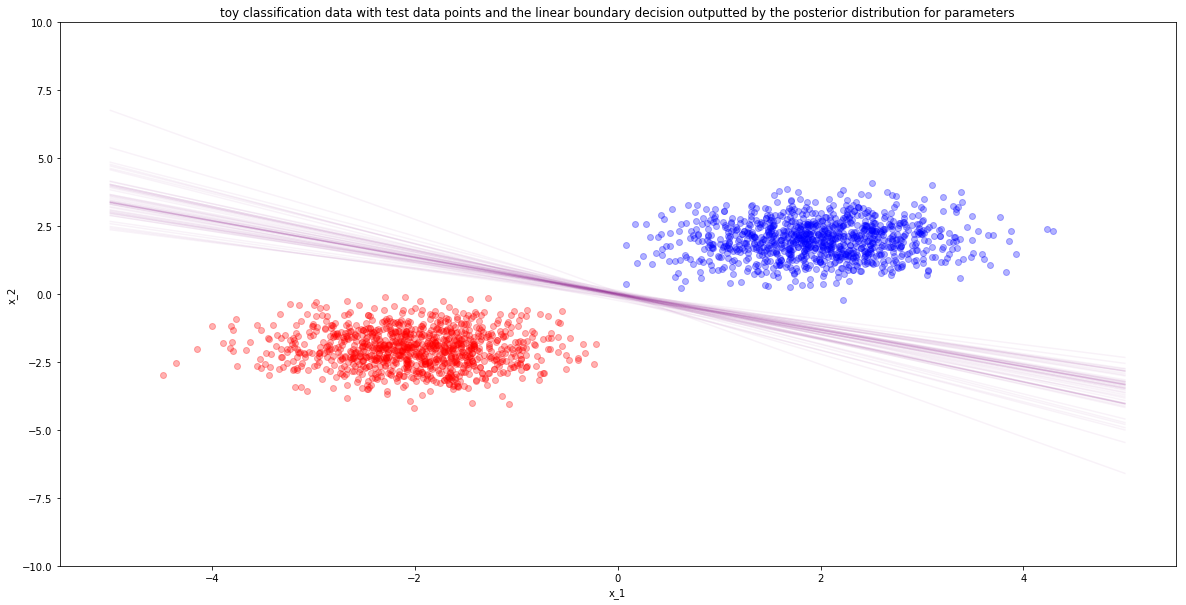

In [15]:

fig, ax = plt.subplots(1, 1, figsize=(20, 10))
for sample in samples:
    slope = lambda x :  -sample[1]/sample[0]*x - sample[2]/sample[0]
    if np.random.uniform()< 0.05:
        ax.plot(np.linspace(-5, 5, 100), [slope(xi) for xi in np.linspace(-5, 5, 100)], color='purple', alpha=0.05)
ax.plot(np.linspace(-5, 5, 100), [slope(xi) for xi in np.linspace(-5, 5, 100)], color='purple', label='Linear Boundary', alpha=0.2)
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')

#for i in range(len(test_points)):
#    pt = test_points[i]
#    if i == 0:
#        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
#    else:
        #ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_ylim(-10, 10)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points and the linear boundary decision outputted by the posterior distribution for parameters')


# NLM

In [5]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 3
input_dim = 2
output_dim = 4

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'prior': 'normal',
               'prior_parameters':{'mean': np.zeros(5), 'covariance_matrix': np.eye(5)},
               'likelihood': 'logistic',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nlm = NLM(architecture, random=random)

In [6]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':500, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
#nlm.fit_MLE(x.T, y.reshape(1,-1), params)


y_ = get_dummies(y).values
X_train, X_test, y_train, y_test = train_test_split(x, y_, train_size=0.8, random_state=random)
nlm.fit_MLE(X_train.T, y_train.T, params)

Iteration 0 lower bound 1.7498303916915297; gradient mag: 1.8835811132333418
Iteration 100 lower bound 1.5355561130712432; gradient mag: 0.4686344825061534
Iteration 200 lower bound 1.2504098403217945; gradient mag: 0.41566136578592056
Iteration 300 lower bound 0.9851583531479937; gradient mag: 0.4343236630144455
Iteration 400 lower bound 0.7680267593641626; gradient mag: 0.35838910605191493


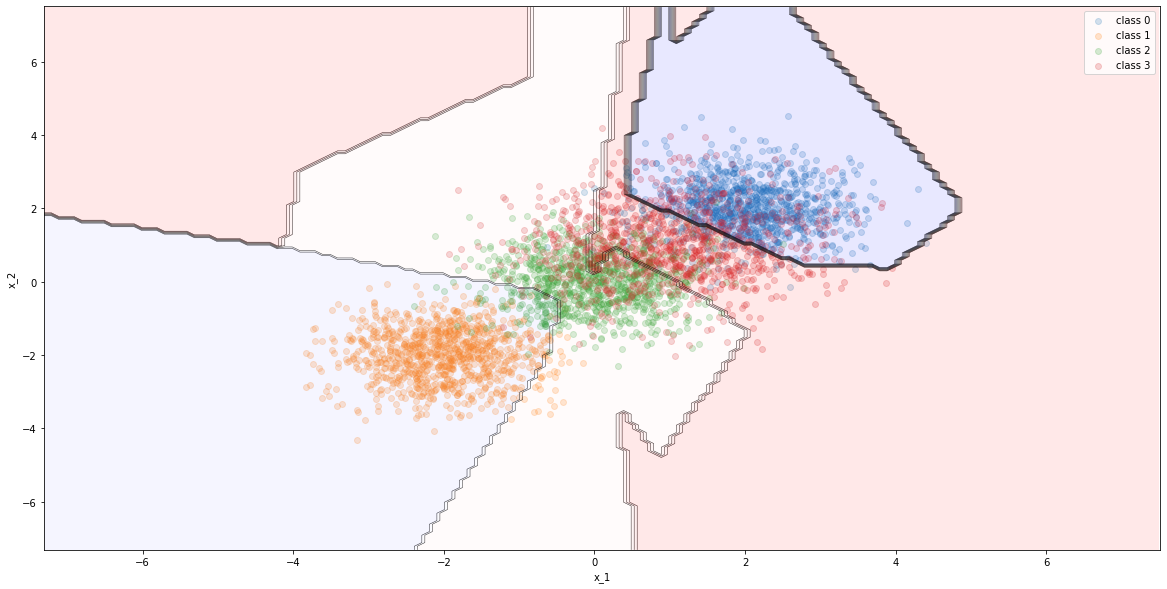

In [7]:
classifier = [Classifier(nlm.weights, nlm.forward)]
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(x, y_, classifier, ax)
plt.show()

In [15]:
import autograd.numpy as np
from pymc3 import Model
import pymc3 as pm
import theano

theano.config.gcc.cxxflags = "-Wno-c++11-narrowing"
import theano.tensor as Th
from scipy.special import softmax


def pymc3_sampling_test(out_last_hidden_layer, output_dim, y, D, mu_wanted=0, tau_wanted=1, samples_wanted=1000,
                       number_chains=2):
        """
        :param out_last_hidden_layer: the feature map after the trained Neural network
        :param output_dim: the output dimension (= number of classes)
        :param y: your training labels
        :param D: the number of hidden nodes (is also the dimensionnality of the output of the feature map)
        :param mu_wanted: mu of the normal prior
        :param tau_wanted: precision of the normal prior
        :param samples_wanted: number of samples generated
        :param number_chains: number of chains ran
        :return: samples from the posterior of the Bayesian Logistic regression
        """
        initialization_pymc3 = nlm.get_feature_map_weights()
        with pm.Model() as replacing_HMC:
            w = pm.Normal('w', mu=0, tau=tau_wanted, shape=(D * output_dim + output_dim))
            linear_combinations = []
            for j in range(output_dim):
                dot = pm.math.dot(out_last_hidden_layer[0].T, w[j * D:j * D + D]) + w[-output_dim+j]
                linear_combi = pm.Deterministic('s' + str(j), dot)
                linear_combinations.append(linear_combi)
            thetas = pm.Deterministic('theta', Th.nnet.softmax(linear_combinations))
            y_obs = pm.Categorical('y_obs', p=thetas.T, observed=y)
            trace = pm.sample(samples_wanted, chains=number_chains,cores=1,init='advi')
        return trace
    
    
traces=pymc3_sampling_test( nlm.forward(nlm.weights,X_train.T,partial=True), 4, y_train.T,5)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 7,401.7:  14%|█▍        | 27699/200000 [01:04<06:42, 428.54it/s]
Convergence achieved at 27700
Interrupted at 27,699 [13%]: Average Loss = 10,489
Sequential sampling (2 chains in 1 job)
NUTS: [w]
Sampling chain 1, 0 divergences: 100%|██████████| 1500/1500 [05:29<00:00,  4.55it/s]
The number of effective samples is smaller than 25% for some parameters.


Text(0.5, 1.0, 'Trace plot')

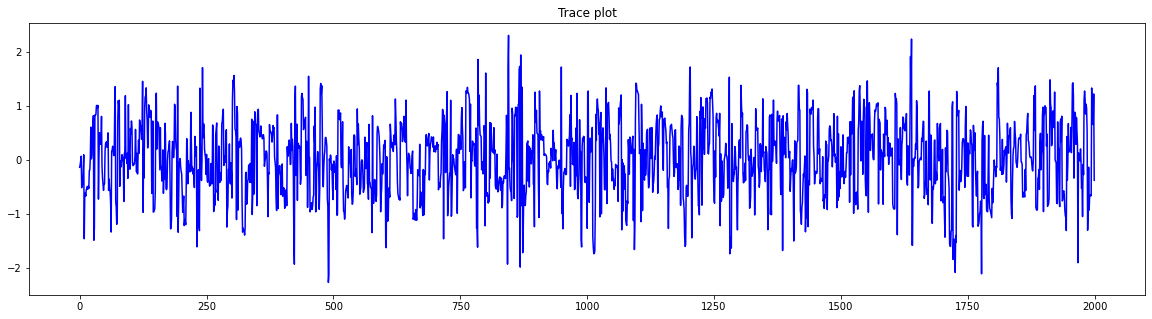

In [18]:
w_0=[]
w_1=[]
w_2=[]
for i in range(len(traces['w'])):    
    w_0.append(traces['w'][i][0])        
    w_1.append(traces['w'][i][1])        
    w_2.append(traces['w'][i][2])
    
fig, ax=plt.subplots(1,1,figsize=(20,5))
ax.plot(range(len(w_0)), w_0, color='b')
ax.set_title('Trace plot')

In [19]:
import numpy
numpy.version.version

'1.19.2'

In [17]:
posterior_weightsior_weights=np.array(traces)
indexes_chosen = random.choices(posterior_weights.shape[1], k=10)
selected_weights = posterior_weights[:, indexes_chosen]  # size : (num_weights, num_models)
# one thing we need to solve about the weights is that this is not the right shape, we expect weights + biases and
index_output_layer = - self.params['H'] * self.params['D_out'] - self.params['D_out']
weights_independent = self.weights[:index_output_layer]
models = []
for weight in selected_weights:
    complete_weight_model = np.array(
        list(weights_independent.flatten()) + list(weight.flatten()))  # make sure we get this right
    complete_weight_model = complete_weight_model.reshape((1, -1))
    models.append(Classifier(complete_weight_model, self.forward))

AttributeError: 'numpy.random.mtrand.RandomState' object has no attribute 'choices'

In [ ]:
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(x, y_, [models], ax)
plt.show()

In [9]:
#nlm.forward(nlm.weights,X_train.T,partial=True)
#nlm.pymc3_sampling(nlm.forward(nlm.weights,X_train.T,partial=True),4,y_train.T,5)
#print(nlm.weights)

samples=nlm.fit_NLM(X_train.T, y_train.T)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w]
Sampling 2 chains:   3%|▎         | 77/3000 [01:10<6:44:35,  8.31s/draws]


ValueError: Not enough samples to build a trace.

In [7]:
models=nlm.sample_models(X_train.T,y_train.T,params,100)

Currently fitting a Neural Network for the Classification task
Iteration 0 lower bound 0.4405735856943233; gradient mag: 0.023686533165845614
Iteration 100 lower bound 0.44009752738059676; gradient mag: 0.02237112955830388
Iteration 200 lower bound 0.439593002742726; gradient mag: 0.03212809373996058
Iteration 300 lower bound 0.43890298943113487; gradient mag: 0.02020651183135509
Iteration 400 lower bound 0.43854700502297733; gradient mag: 0.04052037666800113
Iteration 500 lower bound 0.4382523078791415; gradient mag: 0.015595071154059626
Iteration 600 lower bound 0.4379956470935511; gradient mag: 0.03301711666915809
Iteration 700 lower bound 0.43777139051392827; gradient mag: 0.03942786238444762
Iteration 800 lower bound 0.43757164546195093; gradient mag: 0.03621150739290193
Iteration 900 lower bound 0.4374208641226593; gradient mag: 0.036024264453299794
Iteration 1000 lower bound 0.43730370942084235; gradient mag: 0.0431822579913955
Iteration 1100 lower bound 0.4370807043153734; grad

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w]
Sampling 2 chains: 100%|██████████| 3000/3000 [1:15:28<00:00,  1.84s/draws]
The estimated number of effective samples is smaller than 200 for some parameters.


Posterior samples sampled !
Now, thanks to the posterior, we are going to create 100different classification models


AttributeError: module 'random' has no attribute 'choices'

In [8]:
from platform import python_version
import random
print(python_version())
import random

print (random.__file__)
random.choices(4, k=100)

3.5.6
/Users/gaelancel/anaconda3/lib/python3.5/random.py


AttributeError: module 'random' has no attribute 'choices'